In [1]:
# %pip install mahotas

## Importing Libraries

In [ ]:
# Libary import test

from PIL import Image, ImageEnhance, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, feature
import os
import cv2
import numpy as np

from sklearn.preprocessing import MinMaxScaler # type: ignore
from skimage import color, measure, morphology as ski_morph
from skimage.draw import polygon
from skimage import color, filters, measure, morphology, data
from skimage.morphology import convex_hull_image

# from shapely.geometry import LineString
from sklearn.cluster import KMeans
import random
from sklearn.decomposition import PCA
from scipy import stats as st
import mahotas as mh

import cv2 as cv
from scipy.stats import gaussian_kde


In [3]:
# Set weight & height of image
def image_processing(image, max_height, max_width):
   
    # Convert image to grayscale
    image = image.convert('L')
    
    # Turn image to np.array type
    image_array = np.asarray(image)
    return image_array

##  Image Processing for Microscopic Images

In [4]:
# Updated image_processing function to ensure the correct data type
def image_processing(image, max_height, max_width):
    # Convert image to grayscale
    image = image.convert('L')
    
    # Turn image to np.array type and ensure it is uint8
    image_array = np.asarray(image).astype(np.uint8)
    return image_array

# Function to apply Otsu and RC thresholding using Mahotas and return the binary images
def apply_mahotas_thresholding(im_gray):
    # Otsu thresholding with Mahotas
    otsu_thresh = mh.otsu(im_gray)
    bin_otsu = im_gray > otsu_thresh
    
    # RC thresholding with Mahotas
    rc_thresh = mh.rc(im_gray)
    bin_rc = im_gray > rc_thresh
    
    return otsu_thresh, bin_otsu, rc_thresh, bin_rc

# Display function to show the binary images with threshold values on histogram
def display_binary_images_with_histogram(im_gray, otsu_thresh, bin_otsu, rc_thresh, bin_rc):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # Plot histogram with Otsu and RC thresholds
    ax[0, 0].hist(im_gray.ravel(), bins=255, color='gray')
    ax[0, 0].axvline(otsu_thresh, color='blue', linestyle='--', label=f'Otsu Threshold: {otsu_thresh}')
    ax[0, 0].axvline(rc_thresh, color='red', linestyle='--', label=f'RC Threshold: {rc_thresh}')
    ax[0, 0].set_title('Histogram with Thresholds')
    ax[0, 0].legend()

    # Display Otsu threshold binary image
    ax[0, 1].imshow(bin_otsu, cmap='gray')
    ax[0, 1].set_title(f'Otsu Threshold Binary Image (Threshold: {otsu_thresh})')
    ax[0, 1].axis('off')

    # Display RC threshold binary image
    ax[1, 0].imshow(bin_rc, cmap='gray')
    ax[1, 0].set_title(f'RC Threshold Binary Image (Threshold: {rc_thresh})')
    ax[1, 0].axis('off')

    # Display original grayscale image for reference
    ax[1, 1].imshow(im_gray, cmap='gray')
    ax[1, 1].set_title('Original Grayscale Image')
    ax[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# # Example usage with your own image
# #image_path = '/Users/kchong99/Documents/UW_SUN_LAB/MOFs_Project/Condition_Test_V1/Condition 5 16th.tif'
# # image_path = '/Users/kchong99/Documents/UW_SUN_LAB/MOFs_Project/11:21 powder ratios plus buffer/buffer new #4 j.tif'
# # image_path = '/Users/kchong99/Documents/UW_SUN_LAB/MOFs_Project/11:21 powder ratios plus buffer/buffer new #5 g.tif' # AR < 2
# image_path = '/Users/kchong99/Documents/UW_SUN_LAB/MOFs_Project/Condition_Test_V1/Condition 5 12th.tif' # ar > 2
# # Load and preprocess the image
# image = Image.open(image_path)
# image_gray = image_processing(image, 685, 1000)

# # Apply Mahotas Otsu and RC thresholding
# otsu_thresh, bin_otsu, rc_thresh, bin_rc = apply_mahotas_thresholding(image_gray)

# # Display the results
# display_binary_images_with_histogram(image_gray, otsu_thresh, bin_otsu, rc_thresh, bin_rc)


## Finding the exact area using the scale bar

In [5]:
# Function to detect horizontal straight lines for every contour
def detect_horizontal_lines(contours, slope_tolerance=0.01):
    horizontal_lines = []

    # Iterate through contours
    for idx, contour in enumerate(contours):
        # Contour points
        x_coords, y_coords = contour[:, 1], contour[:, 0]

        # Pairwise line segments
        for i in range(len(x_coords) - 1):
            x1, y1 = x_coords[i], y_coords[i]
            x2, y2 = x_coords[i + 1], y_coords[i + 1]

            # Avoid division by zero and compute slope
            if abs(x2 - x1) > 1e-6:
                slope = (y2 - y1) / (x2 - x1)
            else:
                slope = np.inf

            # Check if the line is horizontal (slope close to 0)
            if abs(slope) <= slope_tolerance:
                horizontal_lines.append(((x1, y1), (x2, y2)))

    return horizontal_lines

# Function to combine horizontal lines that are within 5 pixels
def combine_close_lines(horizontal_lines, pixel_tolerance=5):
    combined_lines = []

    # Sort lines by their starting y-coordinate
    horizontal_lines.sort(key=lambda line: line[0][1])

    for line in horizontal_lines:
        x1, y1, x2, y2 = *line[0], *line[1]

        if not combined_lines:
            combined_lines.append((x1, y1, x2, y2))
        else:
            # Check proximity with the last combined line
            cx1, cy1, cx2, cy2 = combined_lines[-1]

            if abs(y1 - cy1) <= pixel_tolerance and (min(x2, cx2) - max(x1, cx1)) >= -pixel_tolerance:
                # Merge lines if they are close
                combined_lines[-1] = (min(x1, cx1), min(y1, cy1), max(x2, cx2), max(y2, cy2))
            else:
                # Otherwise, add as a new line
                combined_lines.append((x1, y1, x2, y2))

    return combined_lines

# Function to overlay combined horizontal lines and highlight the longest in red
def overlay_horizontal_lines(binary_image, combined_lines):
    # Convert binary image to a 3-channel image for visualization
    overlay_image = np.dstack([binary_image * 255] * 3).astype(np.uint8)

    # Find the longest line
    longest_line = None
    if combined_lines:
        longest_line = max(combined_lines, key=lambda line: np.sqrt((line[2] - line[0])**2 + (line[3] - line[1])**2))
        (x1, y1, x2, y2) = longest_line

        # Highlight the longest line in red
        cv2.line(overlay_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 3)  # Red line

        # Plot starting and ending points of the longest line
        cv2.circle(overlay_image, (int(x1), int(y1)), 5, (255, 0, 0), -1)  # Start point in blue
        cv2.circle(overlay_image, (int(x2), int(y2)), 5, (255, 0, 0), -1)  # End point in yellow

    # Draw all other combined lines in green
    for (x1, y1, x2, y2) in combined_lines:
        if (x1, y1, x2, y2) != longest_line:
            cv2.line(overlay_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Green lines

    return overlay_image, longest_line

# Function to display the overlay
def display_overlay(overlay_image):
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_image)
    plt.title('Binary Image with Combined Horizontal Lines (Longest in Red, Points Highlighted)')
    plt.axis('off')
    plt.show()

# # Detect all contours in the binary image using skimage
# contours = measure.find_contours(bin_rc, level=0.8)

# # Detect horizontal lines in contours
# horizontal_lines = detect_horizontal_lines(contours)

# # Combine horizontal lines that are close to each other
# combined_lines = combine_close_lines(horizontal_lines, pixel_tolerance=5)

# # Overlay combined horizontal lines on the binary image and highlight the longest in red
# overlay_image, longest_line = overlay_horizontal_lines(bin_rc, combined_lines)

# # Display the overlay
# display_overlay(overlay_image)

# # Assuming the actual length of the longest line is 200 micrometers
# actual_length_micrometers = 200

# # Print details of the longest line
# if longest_line:
#     x1, y1, x2, y2 = longest_line
#     length_in_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
#     length_per_pixel = actual_length_micrometers / length_in_pixels
#     print(f"Length of the longest line in pixels: {length_in_pixels:.2f}")
#     print(f"Actual length per pixel: {length_per_pixel:.4f} micrometers per pixel")
    
# else:
#     print("No horizontal lines detected.")
#     length_in_pixels = 450
#     length_per_pixel = actual_length_micrometers / length_in_pixels


## RC Thresholding and Morphological Closing

In [6]:
# Function to apply RC thresholding and return binary images
def apply_rc_thresholding(im_gray):
    # RC thresholding with Mahotas
    rc_thresh = mh.rc(im_gray)
    bin_rc = im_gray > rc_thresh
    return rc_thresh, bin_rc

# Function to apply morphological closing
def apply_morphological_closing(bin_image):
    # Define a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)
    # Apply morphological closing
    closed_image = cv.morphologyEx(bin_image.astype(np.uint8) * 255, cv.MORPH_CLOSE, kernel)
    return closed_image

# Display function to show the RC thresholding results before and after morphological closing
def display_rc_closing_results(im_gray, rc_thresh, bin_rc, closed_image):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Display original grayscale image for reference
    ax[0].imshow(im_gray, cmap='gray')
    ax[0].set_title('Original Grayscale Image')
    ax[0].axis('off')

    # Display RC threshold binary image
    ax[1].imshow(bin_rc, cmap='gray')
    ax[1].set_title(f'RC Threshold Binary Image (Threshold: {rc_thresh})')
    ax[1].axis('off')

    # Display RC threshold binary image after morphological closing
    ax[2].imshow(closed_image, cmap='gray')
    ax[2].set_title('After Morphological Closing')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()


# # Apply RC thresholding
# rc_thresh, bin_rc = apply_rc_thresholding(image_gray)

# # Apply morphological closing on the RC thresholded binary image
# closed_image = apply_morphological_closing(bin_rc)

# # Display results before and after morphological closing
# display_rc_closing_results(image_gray, rc_thresh, bin_rc, closed_image)


## Contour Detection and Filtering for White Regions

In [7]:
def is_contour_enclosing_white_region(contour, image):
    """Check if a contour is enclosing a white region."""
    # Create a mask for the contour
    mask = np.zeros(image.shape, dtype=bool)
    rr, cc = polygon(contour[:, 0], contour[:, 1], shape=image.shape)
    mask[rr, cc] = True

    # Check the number of white pixels inside the contour
    white_pixels_inside = np.sum(mask & (image == 255))  # Pixels inside the contour that are white
    total_pixels_inside = np.sum(mask)  # Total number of pixels inside the contour

    # Check if a large portion of the contour is enclosing white pixels
    # If more than 90% of the area inside the contour is white, return True
    return white_pixels_inside / total_pixels_inside > 0.9 if total_pixels_inside > 0 else False

# Function to normalize the result and find contours
def normalize_and_find_contours(closing, contour_level=0.8):
    """Normalize the closing result and find contours."""
    
    # Normalize the closing result to values between 0 and 1
    normalized_closing = closing / 255.0

    # Find contours at a constant value (e.g., 0.8)
    contours = measure.find_contours(normalized_closing, contour_level)

    return contours

def filter_and_remove_white_region_contours(closing, contours):
    """Filter and remove contours that enclose white regions."""
    filtered_contours = []
    for contour in contours:
        if not is_contour_enclosing_white_region(contour, closing):
            filtered_contours.append(contour)
    return filtered_contours


# Function to display the image and the detected contours
def display_contours(closing, contours):
    """Display the image with detected contours overlaid."""
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(closing, cmap=plt.cm.gray)  # Display the closing result in grayscale

    # Loop through the contours and plot them
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Contours Detected Using measure.find_contours")
    plt.show()

# # Example usage:
# # Normalize the closing image and find contours
# contours = normalize_and_find_contours(closed_image, contour_level=0.8)

# # Filter out contours that enclose white regions
# contours = filter_and_remove_white_region_contours(closed_image, contours)

# # Display the contours on the closing result
# display_contours(closed_image, contours)

## Displaying Contours on the Original Color Image

In [8]:
# Function to display the original color image with detected contours overlaid
def display_contours_on_original_color(original_image, contours):
    """Display the original color image with detected contours overlaid."""
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image)  # Display the original color image

    # Loop through the contours and plot them on the color image
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')  # Overlay contours in red

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Contours Overlaid on Original Color Image")
    plt.show()

# # Example usage:
# # Load the original color image and the grayscale image for processing

# original_image = Image.open(image_path).convert('RGB')  # Load as color

# # Display the contours overlaid on the original color image
# display_contours_on_original_color(original_image, contours)


## Contour Classification by Convexity and Boundary Detection

In [9]:
# Function to calculate convexity and classify contours into blue, red, and boundary
def classify_contours_by_convexity(image_shape, contours, convexity_threshold=0.865):
    """Classify contours based on convexity threshold and identify boundary contours."""
    blue_contours = []
    red_contours = []
    boundary_contours = []

    # Create masks for each contour to check for containment
    contour_masks = []
    for contour in contours:
        mask = np.zeros(image_shape, dtype=bool)
        rr, cc = polygon(contour[:, 0], contour[:, 1], shape=image_shape)
        mask[rr, cc] = True
        contour_masks.append(mask)

    # Classify each contour and check for containment within others
    for i, contour in enumerate(contours):
        mask = contour_masks[i]

        # Calculate convex hull and convexity
        hull = convex_hull_image(mask)
        contour_area = np.sum(mask)
        hull_area = np.sum(hull)
        convexity = contour_area / hull_area

        # Determine if contour is a boundary (contained within another contour)
        is_boundary = any(
            np.all(contour_masks[j][mask]) for j in range(len(contours)) if j != i
        )

        # Classify based on convexity or add to boundary list
        if is_boundary:
            boundary_contours.append(contour)
        elif convexity > convexity_threshold:
            blue_contours.append(contour)
        else:
            red_contours.append(contour)

    return blue_contours, red_contours, boundary_contours

# Function to display the original color image with classified contours overlaid
def display_classified_contours_on_original_color(original_image, blue_contours, red_contours, boundary_contours):
    """Display the original color image with classified contours overlaid."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image)  # Display the original color image

    # Plot blue contours
    for contour in blue_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='blue', label="Blue (Convex)")

    # Plot red contours
    for contour in red_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red', label="Red (Non-Convex)")

    # Plot boundary contours in green
    for contour in boundary_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green', linestyle='--', label="Boundary")

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Classified Contours (Blue: Convex, Red: Non-Convex, Green: Boundary)")
    plt.show()

# Example usage:
# # Classify contours based on convexity and identify boundary contours
# blue_contours, red_contours, boundary_contours = classify_contours_by_convexity(image_gray.shape, contours)

# # Display the contours overlaid on the original color image, classified by convexity and boundary
# display_classified_contours_on_original_color(original_image, blue_contours, red_contours, boundary_contours)


# Activated IFF less than 2 Detected Contours

## Overlaying Minimum Bounding Boxes and Calculating Aspect Ratios and Areas 

In [10]:
def overlay_min_bounding_box_and_aspect_ratio(original_image, contours, label_color):
    """
    Overlay the minimum bounding box for contours on the original image and calculate the aspect ratio and area.

    Parameters:
    - original_image: Original color image.
    - contours: List of contours to process.
    - label_color: Color for the label and box.

    Returns:
    - aspect_ratios: List of aspect ratios calculated for the contours.
    - areas: List of areas calculated for the contours.
    """
    aspect_ratios = []
    areas = []

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image)

    for contour in contours:
        # Convert contour to integer format for OpenCV
        contour_int = np.array(contour, dtype=np.int32)

        # Find the minimum bounding rectangle
        rect = cv2.minAreaRect(contour_int)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Draw the bounding rectangle
        ax.plot(
            [box[i][1] for i in range(4)] + [box[0][1]],
            [box[i][0] for i in range(4)] + [box[0][0]],
            color=label_color,
            linewidth=2,
        )

        # Calculate width, height, aspect ratio, and area
        width = np.linalg.norm(box[0] - box[1])
        height = np.linalg.norm(box[1] - box[2])
        if height > 0 and width > 0:  # Avoid division by zero
            aspect_ratio = max(width / height, height / width)
            
            if aspect_ratio > 20:
                continue
            aspect_ratios.append(aspect_ratio)

            area = cv2.contourArea(contour_int)
            areas.append(area)

            # Overlay aspect ratio and area
            x_center = np.mean([box[i][1] for i in range(4)])
            y_center = np.mean([box[i][0] for i in range(4)])
            ax.text(
                x_center,
                y_center,
                f"Area: {area:.2f}\nAR: {aspect_ratio:.2f}",
                color=label_color,
                fontsize=8,
                ha="center",
                va="center",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
            )

    ax.axis("image")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Bounding Box and Aspect Ratio ({label_color.capitalize()})")
    plt.tight_layout()
    plt.show()

    return aspect_ratios, areas


def process_and_overlay_if_few_contours(original_image, blue_contours, red_contours, boundary_contours, length_per_pixel):
    """
    Check if the sum of contours is less than 3. If so, overlay minimum bounding boxes
    and calculate aspect ratios for the corresponding contours.

    Parameters:
    - original_image: Original color image.
    - blue_contours: List of blue (convex) contours.
    - red_contours: List of red (non-convex) contours.
    - boundary_contours: List of boundary contours.

    Returns:
    - all_aspect_ratios: Combined list of all aspect ratios calculated for the contours.
    - all_areas: Combined list of all areas calculated for the contours.
    """
    total_contours = len(blue_contours) + len(red_contours) + len(boundary_contours)
    all_aspect_ratios = []
    all_areas = []

    if total_contours <= 2:
        print(f"Total contours ({total_contours}) are less than or equal to 2. Processing bounding boxes.")
        if blue_contours:
            blue_ar, blue_areas = overlay_min_bounding_box_and_aspect_ratio(
                original_image, blue_contours, "blue"
            )
            blue_areas = blue_areas * length_per_pixel
            all_aspect_ratios.extend(blue_ar)
            all_areas.extend(blue_areas)
        if red_contours:
            red_ar, red_areas = overlay_min_bounding_box_and_aspect_ratio(
                original_image, red_contours, "red"
            )
            red_areas = red_areas * length_per_pixel
            all_aspect_ratios.extend(red_ar)
            all_areas.extend(red_areas)
        if boundary_contours:
            green_ar, green_areas = overlay_min_bounding_box_and_aspect_ratio(
                original_image, boundary_contours, "green"
            )
            all_aspect_ratios.extend(green_ar)
            all_areas.extend(green_areas)
    else:
        print(f"Total contours ({total_contours}) are sufficient. Skipping bounding box overlay.")

    return all_aspect_ratios, all_areas


# Example Usage:
# # Assuming `original_image`, `blue_contours`, `red_contours`, and `boundary_contours` are defined
# blue_aspect_ratios, blue_areas = process_and_overlay_if_few_contours(
#     original_image, blue_contours, red_contours, boundary_contours
# )

# # Output aspect ratios and areas
# print("All Aspect Ratios:", blue_aspect_ratios)
# print("All Areas:", blue_areas)


# Else (If more than 2 detected contours)

## Processing Blue Contours: Areas and Aspect Ratios

In [11]:
def process_blue_contours(image_gray, original_image, blue_contours):
    """Calculate areas and aspect ratios for blue contours and draw bounding rectangles."""
    
    # Lists to store areas and aspect ratios
    areas = []
    aspect_ratios = []

    # Display the original color image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image)

    for idx, contour in enumerate(blue_contours):
        # Create a binary mask for the contour
        mask = np.zeros(image_gray.shape, dtype=bool)
        rr, cc = polygon(contour[:, 0], contour[:, 1], shape=image_gray.shape)
        mask[rr, cc] = True

        # Calculate area and append to the list
        area = np.sum(mask)
        areas.append(area)

        # Convert contour to integer format for OpenCV
        contour_int = np.array(contour, dtype=np.int32)

        # Find the minimum bounding rectangle
        rect = cv2.minAreaRect(contour_int)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Draw the bounding rectangle
        ax.plot(
            [box[i][1] for i in range(4)] + [box[0][1]],
            [box[i][0] for i in range(4)] + [box[0][0]],
            color='blue',
            linewidth=1,
        )

        # Calculate aspect ratio and append to the list
        width, height = rect[1]
        if height > 0 and width > 0:
            aspect_ratio = max(width / height, height / width)
            
            # if aspect_ratio >20:
            #     continue
        else:
            aspect_ratio = 0  # Assign default value for invalid aspect ratio
        aspect_ratios.append(aspect_ratio)
        
        # # Calculate the center of the bounding rectangle to overlay aspect ratio
        # x_center = np.mean([box[i][1] for i in range(4)])
        # y_center = np.mean([box[i][0] for i in range(4)])
        
        # # Overlay aspect ratio on the image
        # ax.text(
        #     x_center,
        #     y_center,
        #     f"{aspect_ratio:.2f}",
        #     color='blue',
        #     fontsize=8,
        #     ha='center',
        #     va='center',
        #     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'),
        # )

        # Debugging: Print current index, area, and aspect ratio
        # print(f"Contour {idx}: Area = {area}, Aspect Ratio = {aspect_ratio}")

    # Final debug check
    print(f"Total areas: {len(areas)}, Total aspect ratios: {len(aspect_ratios)}")
    
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Blue Contours with Bounding Rectangles")
    plt.show()

    return areas, aspect_ratios

# blue_areas, blue_aspect_ratios = process_blue_contours(image_gray, original_image, blue_contours)


## Plotting Histograms with KDE Curves, Peaks, and Standard Deviation

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Function to plot top-and-bottom histograms with KDE curves, identify peaks, and overlay standard deviation
def plot_top_bottom_histograms_with_peak_curve_and_std(areas, aspect_ratios):
    """Plot top and bottom histograms with KDE curves, identify peaks, and overlay standard deviation."""
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1]})

    # Top histogram: Areas
    axs[0].hist(areas, bins=200, color='blue', alpha=0.7, density=True, label="Histogram")
    # Calculate KDE curve
    kde_area = gaussian_kde(areas)
    x_area = np.linspace(min(areas), max(areas), 1000)
    y_area = kde_area(x_area)
    axs[0].plot(x_area, y_area, 'r-', label="KDE Curve")
    # Identify the peak
    peak_area = x_area[np.argmax(y_area)]
    axs[0].axvline(peak_area, color='black', linestyle='--', label=f"Peak: {peak_area:.2f}")
    # Overlay standard deviation
    mean_area = np.mean(areas)
    std_area = np.std(areas)
    axs[0].axvline(mean_area - std_area, color='purple', linestyle='--', label=f"Mean - Std Dev: {mean_area - std_area:.2f}")
    axs[0].axvline(mean_area + std_area, color='orange', linestyle='--', label=f"Mean + Std Dev: {mean_area + std_area:.2f}")
    axs[0].set_xlabel('Area')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Histogram of Blue Contour Areas with Peak Curve and Std Dev')
    axs[0].legend()

    # Bottom histogram: Aspect Ratios
    axs[1].hist(aspect_ratios, bins=200, color='green', alpha=0.7, density=True, label="Histogram")
    # Calculate KDE curve
    kde_ar = gaussian_kde(aspect_ratios)
    x_ar = np.linspace(min(aspect_ratios), max(aspect_ratios), 1000)
    y_ar = kde_ar(x_ar)
    axs[1].plot(x_ar, y_ar, 'r-', label="KDE Curve")
    # Identify the peak
    peak_ar = x_ar[np.argmax(y_ar)]
    axs[1].axvline(peak_ar, color='black', linestyle='--', label=f"Peak: {peak_ar:.2f}")
    # Overlay standard deviation
    mean_ar = np.mean(aspect_ratios)
    std_ar = np.std(aspect_ratios)
    axs[1].axvline(mean_ar - std_ar, color='purple', linestyle='--', label=f"Mean - Std Dev: {mean_ar - std_ar:.2f}")
    axs[1].axvline(mean_ar + std_ar, color='orange', linestyle='--', label=f"Mean + Std Dev: {mean_ar + std_ar:.2f}")
    axs[1].set_xlabel('Aspect Ratio')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Histogram of Blue Contour Aspect Ratios with Peak Curve and Std Dev')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return peak_area, peak_ar, mean_area, std_area, mean_ar, std_ar

# # Example usage:
# peak_area, peak_ar, mean_area, std_area, mean_ar, std_ar = plot_top_bottom_histograms_with_peak_curve_and_std(areas, aspect_ratios)

# # Print the peaks and standard deviations
# print(f"Peak Area: {peak_area}")
# print(f"Mean Area: {mean_area}, Std Dev Area: {std_area}")
# print(f"Peak Aspect Ratio: {peak_ar}")
# print(f"Mean Aspect Ratio: {mean_ar}, Std Dev Aspect Ratio: {std_ar}")


## Filtering and Overlaying Contours with Area Limits

In [13]:
def filter_and_overlay_all_contours_with_upper_limit(
    original_image, image_gray, blue_contours, red_contours, green_contours, mean_area, std_dev_area, peak_area, length_per_pixel
):
    """Filter blue, red, and green (boundary) contours based on area range and overlay them."""
    filtered_blue_contours = []
    filtered_red_contours = []
    filtered_green_contours = []
    blue_aspect_ratios = []  # List to store aspect ratios of blue contours
    blue_contour_areas = []
    upper_limit = mean_area + std_dev_area + 300000  # Value 50000 from trial and error
    min_area = mean_area  # Minimum area as mean_area or peak_area (if there are a lot of impurities)

    img_height, img_width = image_gray.shape  # Image dimensions

    # Overlay the filtered contours
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image)

    # Filter blue contours based on area range
    for contour in blue_contours:
        # Create a binary mask for the contour
        mask = np.zeros(image_gray.shape, dtype=bool)
        rr, cc = polygon(contour[:, 0], contour[:, 1], shape=image_gray.shape)
        mask[rr, cc] = True

        # Calculate area
        area = np.sum(mask)

        # Convert contour to integer format for OpenCV
        contour_int = np.array(contour, dtype=np.int32)

        # Find the minimum bounding rectangle
        rect = cv2.minAreaRect(contour_int)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Check if the bounding box touches the edge of the image
        touches_edge = any(
            (point[1] <= 0 or point[1] >= img_width - 1 or point[0] <= 0 or point[0] >= img_height - 1)
            for point in box
        )

        # Keep blue contours with an area in the valid range and not touching the edges
        if min_area <= area <= upper_limit and not touches_edge:

            # Draw the bounding rectangle
            ax.plot(
                [box[i][1] for i in range(4)] + [box[0][1]],
                [box[i][0] for i in range(4)] + [box[0][0]],
                color="blue",
                linewidth=1,
            )

            # Calculate aspect ratio
            width, height = rect[1]
            aspect_ratio = max(width / height, height / width) if height > 0 and width > 0 else 0
            
            if aspect_ratio > 20:
                continue
            
            # Append valid aspect ratio to the list
            blue_aspect_ratios.append(aspect_ratio)
            
            filtered_blue_contours.append(contour)
            blue_contour_areas.append(area)  # Store the area of the contour
            
            area = area * length_per_pixel

            # # Calculate center of the bounding box
            # x_center = np.mean([box[i][1] for i in range(4)])
            # y_center = np.mean([box[i][0] for i in range(4)])

            # # Overlay area and aspect ratio on the image
            # ax.text(
            #     x_center,
            #     y_center,
            #     f"Area:{area:.0f}\n AR:{aspect_ratio:.2f}",
            #     color="blue",
            #     fontsize=8,
            #     ha="center",
            #     va="center",
            #     bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
            # )
            
            # Calculate a position beside the bounding box (top-left corner of the box)
            top_left_x = np.min([point[1] for point in box])
            top_left_y = np.min([point[0] for point in box])

            # Overlay the area and aspect ratio beside the bounding box
            ax.text(
                top_left_x+100,  # Slightly left of the box
                top_left_y,  # Slightly above the box
                f"Area: {area:.2f}\nAR: {aspect_ratio:.2f}",
                color="blue",
                fontsize=8,
                ha="right",  # Align text to the right
                va="bottom",  # Align text at the bottom
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
            )
            
            

    # Filter red contours based on area range
    for contour in red_contours:
        mask = np.zeros(image_gray.shape, dtype=bool)
        rr, cc = polygon(contour[:, 0], contour[:, 1], shape=image_gray.shape)
        mask[rr, cc] = True
        area = np.sum(mask)
        if area >= min_area:
            filtered_red_contours.append(contour)

    # Filter green contours (boundary) based on area range
    for contour in green_contours:
        mask = np.zeros(image_gray.shape, dtype=bool)
        rr, cc = polygon(contour[:, 0], contour[:, 1], shape=image_gray.shape)
        mask[rr, cc] = True
        filtered_green_contours.append(contour)

    # Plot filtered blue contours
    for contour in filtered_blue_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="blue", label="Blue Contours")

    # Plot filtered red contours
    for contour in filtered_red_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red", label="Red Contours")

    # Plot filtered green contours
    for contour in filtered_green_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="green", label="Green Contours")

    min_area = min_area * length_per_pixel
    upper_limit = upper_limit * length_per_pixel
    
    ax.axis("image")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Filtered Contours with {min_area:.2f} ≤ Area ≤ {upper_limit:.2f} in µm²")
    plt.show()

    return filtered_blue_contours, blue_contour_areas, filtered_red_contours, filtered_green_contours, blue_aspect_ratios



# # Example usage:
# # Assuming `areas`, `original_image`, `image_gray`, `blue_contours`, `red_contours`, and `green_contours` are defined
# peak_area, _, mean_area, std_dev_area, mean_ar, _ = plot_top_bottom_histograms_with_peak_curve_and_std(
#     blue_areas, blue_aspect_ratios
# )


# # Replacement of Value (To ensure most contours are detected)
# if peak_area > 10000:
#     peak_area = 1000

# filtered_blue_contours, blue_contour_areas, filtered_red_contours, filtered_green_contours, blue_aspect_ratios = filter_and_overlay_all_contours_with_upper_limit(
#     original_image, image_gray, blue_contours, red_contours, boundary_contours, mean_area, std_dev_area, peak_area
# )

# print(f"Number of Filtered Blue Contours: {len(filtered_blue_contours)}")
# print(f"Number of Red contours: {len(filtered_red_contours)}")
# print(f"Number of Green contours: {len(filtered_green_contours)}")

# actual_blue_contour_areas = []

# # Print the areas of filtered blue contours
# print("Filtered Blue Contour Areas:")
# for idx, blue_contour_area in enumerate(blue_contour_areas):
#     blue_contour_area = blue_contour_area * length_per_pixel
#     actual_blue_contour_areas.append(blue_contour_area)
#     print(f"Contour {idx + 1}: Area = {blue_contour_area}")



## Blue Aspect Ratio Analysis with Box Plot

In [14]:
def analyze_and_plot_blue_aspect_ratios(blue_aspect_ratios):
    """
    Create a box plot for the aspect ratios of the filtered blue contours
    and calculate the mean and standard deviation with a legend overlay.

    Parameters:
    - blue_aspect_ratios: List of aspect ratios for the filtered blue contours.

    Returns:
    - mean_ar: Mean of the blue aspect ratios.
    - std_dev_ar: Standard deviation of the blue aspect ratios.
    """
    # Convert the list to a NumPy array for calculations
    blue_aspect_ratios = np.array(blue_aspect_ratios)

    # Calculate mean and standard deviation
    mean_ar = np.mean(blue_aspect_ratios)
    std_dev_ar = np.std(blue_aspect_ratios)

    # Print the statistics
    print(f"Mean Aspect Ratio (Blue Contours): {mean_ar:.2f}")
    print(f"Standard Deviation (Blue Contours): {std_dev_ar:.2f}")

    # Create the box plot
    plt.figure(figsize=(8, 6))
    boxplot = plt.boxplot(
        blue_aspect_ratios,
        vert=True,
        patch_artist=True,
        boxprops=dict(facecolor='cyan', color='cyan')
    )
    plt.title("Box Plot of Aspect Ratios for Filtered Blue Contours")
    plt.ylabel("Aspect Ratio")
    plt.xticks([1], ["Blue Contours"])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a legend with mean and standard deviation
    plt.legend(
        [boxplot["boxes"][0]],
        [f"Mean: {mean_ar:.2f}, SD: {std_dev_ar:.2f}"],
        loc="upper right",
        fontsize=10,
        frameon=True,
        facecolor="white",
        edgecolor="black"
    )

    # Show the plot
    plt.tight_layout()
    plt.show()

    return mean_ar, std_dev_ar


# Example usage
# # Assuming `blue_aspect_ratios` is already defined
# mean_blue_ar, std_dev_blue_ar = analyze_and_plot_blue_aspect_ratios(blue_aspect_ratios)


## Detecting and Grouping Lines by Angle in Red Contours

In [15]:
def detect_and_group_lines_per_contour(binary_background, red_contours, group_threshold=15):
    """
    Detect and group lines within each red contour based on angle similarity.
    Remove lines shorter than 5 pixels.

    Parameters:
    - binary_background: Binary image used for reference.
    - red_contours: List of red contours to detect lines.
    - group_threshold: The angle threshold in degrees for grouping lines within a contour.

    Returns:
    - grouped_lines_per_contour: A list of lists, where each inner list contains grouped lines for a specific contour.
    """
    def calculate_angle(x1, y1, x2, y2):
        return np.degrees(np.arctan2(y2 - y1, x2 - x1))

    grouped_lines_per_contour = []

    for red_contour in red_contours:
        # Create a mask for the current red contour
        red_mask = np.zeros_like(binary_background, dtype=np.uint8)
        rr, cc = polygon(red_contour[:, 0], red_contour[:, 1], red_mask.shape)
        red_mask[rr, cc] = 255

        # Use Canny edge detection to find edges in the red contour mask
        edges = cv2.Canny(red_mask, 50, 150)

        # Use Probabilistic Hough Line Transform to detect line segments
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=20, maxLineGap=5)

        if lines is not None:
            # Store lines and their angles, filtering out lines shorter than 20 pixels
            line_groups = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate the Euclidean distance
                if length >= 5:  # Filter out lines shorter than 5 pixels
                    angle = calculate_angle(x1, y1, x2, y2)
                    line_groups.append({"line": [x1, y1, x2, y2], "angle": angle})

            # Group lines based on angle similarity within the current contour
            grouped_lines = []
            while line_groups:
                current_line = line_groups.pop(0)
                current_angle = current_line["angle"]
                current_group = [current_line["line"]]
                new_group = []

                # Compare the current line with all other lines in the same contour
                for other_line in line_groups:
                    other_angle = other_line["angle"]

                    # If the angle difference is within the threshold, group them together
                    if abs(current_angle - other_angle) <= group_threshold:
                        current_group.append(other_line["line"])
                    else:
                        new_group.append(other_line)

                # Add the group to the grouped lines
                grouped_lines.append(current_group)
                line_groups = new_group

            # Store the grouped lines for the current contour
            grouped_lines_per_contour.append(grouped_lines)

    return grouped_lines_per_contour


def plot_grouped_lines_per_contour_on_original_image(original_image, grouped_lines_per_contour):
    """
    Plot the grouped lines for each red contour with different colors for each group on the original image.

    Parameters:
    - original_image: Original image for reference.
    - grouped_lines_per_contour: List of lists, where each inner list contains grouped lines for a specific contour.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Show the original image
    ax.imshow(original_image)

    # Plot each contour's grouped lines with different colors for each group
    for grouped_lines in grouped_lines_per_contour:
        for group in grouped_lines:
            # Generate a random color for each group
            color = (random.random(), random.random(), random.random())  # RGB values between 0 and 1 for matplotlib

            # Plot all lines in the group with the same color
            for line in group:
                x1, y1, x2, y2 = line
                ax.plot([x1, x2], [y1, y2], color=color, linewidth=2, linestyle='-')

    # Set title and axis settings
    ax.set_title('Grouped Lines by Angle Within Each Contour (Overlaid on Original Image)')
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Example Usage:
# # Detect and group lines within each contour based on angle similarity
# binary_background = np.zeros_like(image_gray, dtype=np.uint8)
# grouped_lines_per_contour = detect_and_group_lines_per_contour(binary_background, filtered_red_contours, group_threshold=15)

# #Plot the grouped lines for each contour on the original image
# plot_grouped_lines_per_contour_on_original_image(original_image, grouped_lines_per_contour)


# IFF AR > 2

## Classification of Red Contours by Grouped Line Clusters

In [16]:
def count_and_print_grouped_lines_per_contour(grouped_lines_per_contour, filtered_red_contours):
    """
    Count and print the number of groups and the quantity of lines in each group
    for the remaining red contours.

    Parameters:
    - grouped_lines_per_contour: List of grouped lines for each contour.
    - remaining_red_contours: List of remaining red contours.
    """
    print("Grouped Lines Information for Remaining Red Contours:")
    for i, (grouped_lines, contour) in enumerate(zip(grouped_lines_per_contour, filtered_red_contours)):
        print(f"\nContour {i + 1}:")
        print(f"Number of Groups: {len(grouped_lines)}")
        for j, group in enumerate(grouped_lines):
            print(f"  Group {j + 1}: {len(group)} lines")


# # Example Usage:
# # Detect and group lines within each contour based on angle similarity
# binary_background = np.zeros_like(image_gray, dtype=np.uint8)
# grouped_lines_per_contour = detect_and_group_lines_per_contour(binary_background, filtered_red_contours, group_threshold=10)

# # Assuming `remaining_red_contours` has been defined (filtered from red contours)
# count_and_print_grouped_lines_per_contour(grouped_lines_per_contour, filtered_red_contours)


## Best-Fit Bounding Boxes and Aspect Ratio Filtering For Overlapping Crystals

In [17]:
def plot_minimum_bounding_boxes_for_large_groups_with_aspect_ratios(
    original_image, grouped_lines_per_contour, filtered_red_contours, min_AR=1.5, max_AR=5.0, max_groups=5
):
    """
    Plot the minimum bounding boxes for groups of lines in a contour
    if the group contains more than 3 lines, filter based on aspect ratio,
    and skip contours with too many grouped lines.

    Parameters:
    - original_image: Original image for reference.
    - grouped_lines_per_contour: List of grouped lines for each contour.
    - filtered_red_contours: List of red contours corresponding to the grouped lines.
    - min_AR: Minimum allowable aspect ratio for bounding boxes.
    - max_AR: Maximum allowable aspect ratio for bounding boxes.
    - max_groups: Maximum allowable number of grouped lines per contour.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Show the original image
    ax.imshow(original_image)

    red_aspect_ratios = []  # Store valid aspect ratios

    # Iterate over contours and their grouped lines
    for contour, grouped_lines in zip(filtered_red_contours, grouped_lines_per_contour):
        # Skip contours with too many grouped lines
        
        # Plot the contour for reference
        ax.plot(contour[:, 1], contour[:, 0], 'g-', linewidth=2, label='Contour')
        
        if len(grouped_lines) > max_groups:
            print(f"Skipping contour with {len(grouped_lines)} grouped lines (exceeds {max_groups}).")
            continue

        # Plot bounding boxes for each group of lines with more than 3 lines
        for group in grouped_lines:
            if len(group) < 3:
                continue  # Skip groups with 3 or fewer lines

            # Flatten lines into a point cloud
            points = []
            for line in group:
                x1, y1, x2, y2 = line
                points.extend([[x1, y1], [x2, y2]])
            points = np.array(points)

            # Compute the bounding box using PCA
            if points.shape[0] > 0:
                pca = PCA(n_components=2)
                pca.fit(points)
                transformed_points = pca.transform(points)
                min_x, min_y = np.min(transformed_points, axis=0)
                max_x, max_y = np.max(transformed_points, axis=0)

                box_transformed = np.array([
                    [min_x, min_y],
                    [max_x, min_y],
                    [max_x, max_y],
                    [min_x, max_y]
                ])
                box = pca.inverse_transform(box_transformed)

                # Calculate and filter by aspect ratio (width / height)
                width = np.linalg.norm(box[0] - box[1])
                height = np.linalg.norm(box[1] - box[2])
                if height > 0:  # Avoid division by zero
                    aspect_ratio = width / height
                    if aspect_ratio < 1:
                        aspect_ratio = 1 / aspect_ratio  # Ensure aspect ratio is always >= 1
                    
                    # Filter based on aspect ratio
                    if aspect_ratio < min_AR or aspect_ratio > max_AR:
                        print(f"Skipping box with aspect ratio {aspect_ratio:.2f} (not between {min_AR} and {max_AR})")
                        continue

                    # Append valid aspect ratio to the list
                    red_aspect_ratios.append(aspect_ratio)

                    # Overlay the aspect ratio on the bounding box
                    x_center = np.mean([box[i][0] for i in range(4)])
                    y_center = np.mean([box[i][1] for i in range(4)])
                    ax.text(
                        x_center,
                        y_center,
                        f"{aspect_ratio:.2f}",
                        color="red",
                        fontsize=8,
                        ha="center",
                        va="center",
                        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
                    )

                # Plot the bounding box
                ax.plot(
                    [box[i][0] for i in range(4)] + [box[0][0]],
                    [box[i][1] for i in range(4)] + [box[0][1]],
                    'r-', linewidth=2, label='Bounding Box (Group > 3 lines)'
                )

    ax.set_title('Minimum Bounding Boxes for Groups of Lines (Filtered by Aspect Ratio and Group Count)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return red_aspect_ratios


# # Detect and group lines within contours
# binary_background = np.zeros_like(image_gray, dtype=np.uint8)
# grouped_lines_per_contour = detect_and_group_lines_per_contour(binary_background, filtered_red_contours, group_threshold=10)

# # Plot the minimum bounding boxes for groups with more than 3 lines and valid aspect ratios
# red_aspect_ratios = plot_minimum_bounding_boxes_for_large_groups_with_aspect_ratios(
#     original_image, grouped_lines_per_contour, filtered_red_contours, min_AR=2, max_AR=mean_blue_ar + 3 * std_dev_blue_ar, max_groups=5
# )

# # Output results
# print(f"Valid Aspect Ratios: {red_aspect_ratios}")


In [18]:
def plot_minimum_bounding_boxes_with_yellow_for_remaining(
    original_image, grouped_lines_per_contour, filtered_red_contours, min_AR=1.5, max_AR=5.0, max_groups=5
):
    """
    Plot the minimum bounding boxes for groups of lines in a contour:
    - Red for groups with more than 3 lines and valid aspect ratios.
    - Yellow for remaining contours without a bounding box, excluding edge-touching boxes.

    Parameters:
    - original_image: Original image for reference.
    - grouped_lines_per_contour: List of grouped lines for each contour.
    - filtered_red_contours: List of red contours corresponding to the grouped lines.
    - min_AR: Minimum allowable aspect ratio for bounding boxes.
    - max_AR: Maximum allowable aspect ratio for bounding boxes.
    - max_groups: Maximum allowable number of grouped lines per contour.

    Returns:
    - red_aspect_ratios: List of valid aspect ratios.
    - processed_contours: List of processed contours.
    - unprocessed_contours: List of unprocessed contours.
    - box_information: List of bounding box coordinates for processed contours.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Convert the image to NumPy array if needed
    if not isinstance(original_image, np.ndarray):
        original_image = np.array(original_image)
    
    img_height, img_width = original_image.shape[:2]

    # Show the original image
    ax.imshow(original_image)

    red_aspect_ratios = []  # Store valid aspect ratios
    processed_contours = []  # Track contours with valid red bounding boxes
    unprocessed_contours = []  # Track unprocessed contours
    box_information = []  # Store box coordinates for processed contours

    num_processed = 0  # Counter for processed contours
    num_unprocessed = 0  # Counter for unprocessed contours

    # Iterate over contours and their grouped lines
    for contour, grouped_lines in zip(filtered_red_contours, grouped_lines_per_contour):
        # Skip contours with too many grouped lines
        if len(grouped_lines) > max_groups:
            print(f"Skipping contour with {len(grouped_lines)} grouped lines (exceeds {max_groups}).")
            continue

        valid_box_found = False
        for group in grouped_lines:
            if len(group) < 3:
                continue  # Skip groups with 3 or fewer lines

            # Flatten lines into a point cloud
            points = []
            for line in group:
                x1, y1, x2, y2 = line
                points.extend([[x1, y1], [x2, y2]])
            points = np.array(points)

            # Compute the bounding box using PCA
            if points.shape[0] > 0:
                pca = PCA(n_components=2)
                pca.fit(points)
                transformed_points = pca.transform(points)
                min_x, min_y = np.min(transformed_points, axis=0)
                max_x, max_y = np.max(transformed_points, axis=0)

                box_transformed = np.array([
                    [min_x, min_y],
                    [max_x, min_y],
                    [max_x, max_y],
                    [min_x, max_y]
                ])
                box = pca.inverse_transform(box_transformed)

                # Calculate and filter by aspect ratio (width / height)
                width = np.linalg.norm(box[0] - box[1])
                height = np.linalg.norm(box[1] - box[2])
                if height > 0:  # Avoid division by zero
                    aspect_ratio = width / height
                    if aspect_ratio < 1:
                        aspect_ratio = 1 / aspect_ratio  # Ensure aspect ratio is always >= 1
                    
                    # Filter based on aspect ratio
                    if aspect_ratio < min_AR or aspect_ratio > max_AR:
                        print(f"Skipping box with aspect ratio {aspect_ratio:.2f} (not between {min_AR} and {max_AR})")
                        continue

                    # Check if the bounding box touches the edge of the image
                    touches_edge = any(
                        (point[0] <= 0 or point[0] >= img_width - 1 or point[1] <= 0 or point[1] >= img_height - 1)
                        for point in box
                    )
                    if touches_edge:
                        print("Skipping red bounding box that touches the image edge.")
                        continue

                    # Append valid aspect ratio to the list
                    red_aspect_ratios.append(aspect_ratio)
                    valid_box_found = True
                    box_information.append(box)

                    # Overlay the aspect ratio on the bounding box
                    x_center = np.mean([box[i][0] for i in range(4)])
                    y_center = np.mean([box[i][1] for i in range(4)])
                    ax.text(
                        x_center,
                        y_center,
                        f"{aspect_ratio:.2f}",
                        color="red",
                        fontsize=8,
                        ha="center",
                        va="center",
                        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
                    )

                    # Plot the bounding box
                    ax.plot(
                        [box[i][0] for i in range(4)] + [box[0][0]],
                        [box[i][1] for i in range(4)] + [box[0][1]],
                        'r-', linewidth=2, label='Bounding Box (Group > 3 lines)'
                    )

        if valid_box_found:
            processed_contours.append(contour)
            num_processed += 1

    # Plot yellow boxes for contours without red bounding boxes
    for contour in filtered_red_contours:
        if not any(np.array_equal(contour, proc_contour) for proc_contour in processed_contours):
            # Compute the minimum bounding box for the entire contour
            x_coords = contour[:, 1]
            y_coords = contour[:, 0]
            min_x, min_y = np.min(x_coords), np.min(y_coords)
            max_x, max_y = np.max(x_coords), np.max(y_coords)
            box = np.array([
                [min_x, min_y],
                [max_x, min_y],
                [max_x, max_y],
                [min_x, max_y]
            ])
            
            # Calculate the width and height of the bounding box
            width = max_x - min_x
            height = max_y - min_y

            # Calculate the aspect ratio of the bounding box #JUST ADDED
            if height > 0:  # Avoid division by zero
                aspect_ratio = max(width / height, height / width)  # Ensure aspect ratio >= 1
                if aspect_ratio > 20:
                    print(f"Skipping contour with aspect ratio {aspect_ratio:.2f} (greater than 15).")
                    continue


            # Check if the yellow bounding box touches the edge of the image
            touches_edge = any(
                (point[0] <= 0 or point[0] >= img_width - 1 or point[1] <= 0 or point[1] >= img_height - 1)
                for point in box
            )
            if touches_edge:
                print("Skipping yellow bounding box that touches the image edge.")
                continue

            # Plot the yellow bounding box
            ax.plot(
                [box[i][0] for i in range(4)] + [box[0][0]],
                [box[i][1] for i in range(4)] + [box[0][1]],
                'y-', linewidth=2, label='Yellow Bounding Box (No Red Box)'
            )
            unprocessed_contours.append(contour)
            num_unprocessed += 1

    ax.set_title('Bounding Boxes for Groups of Lines (Filtered by Aspect Ratio and Group Count)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


    return red_aspect_ratios, processed_contours, unprocessed_contours, box_information


# # Usage Example
# # binary_background = np.zeros_like(image_gray, dtype=np.uint8)
# # grouped_lines_per_contour = detect_and_group_lines_per_contour(binary_background, filtered_red_contours, group_threshold=10)

# red_aspect_ratios, processed_contours, unprocessed_contours, box_information = plot_minimum_bounding_boxes_with_yellow_for_remaining(
#     original_image, grouped_lines_per_contour, filtered_red_contours, min_AR=2, max_AR=mean_blue_ar + 3 * std_dev_blue_ar, max_groups=5
# )


# print(f"Number of processed contours: {len(processed_contours)}")
# print(f"Number of unprocessed contours: {len(unprocessed_contours)}")
# print(f"Valid Aspect Ratios: {red_aspect_ratios}")
# print(f"Box Information: {len(box_information)}")

## Overlaying the Area of the Clusters

In [19]:
def overlay_unprocessed_contour_areas(
    original_image, unprocessed_contours, length_per_pixel
):
    """
    Overlay the area of unprocessed contours onto the original image.

    Parameters:
    - original_image: The original image for reference.
    - unprocessed_contours: List of unprocessed contours.

    Returns:
    - areas: List of areas for each unprocessed contour.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Convert the image to NumPy array if needed
    if not isinstance(original_image, np.ndarray):
        original_image = np.array(original_image)

    img_height, img_width = original_image.shape[:2]

    # Show the original image
    ax.imshow(original_image)

    areas = []  # Store areas of unprocessed contours

    for contour in unprocessed_contours:
        # Calculate the minimum bounding box for the contour
        x_coords = contour[:, 1]
        y_coords = contour[:, 0]
        min_x, min_y = np.min(x_coords), np.min(y_coords)
        max_x, max_y = np.max(x_coords), np.max(y_coords)
        box = np.array([
            [min_x, min_y],
            [max_x, min_y],
            [max_x, max_y],
            [min_x, max_y]
        ])

        # Calculate the area of the contour
        contour_area = cv2.contourArea(contour.astype(np.int32))
        contour_area = contour_area * length_per_pixel
        areas.append(contour_area)

        # # Overlay the contour area within the yellow bounding box
        # x_center = (min_x + max_x) / 2
        # y_center = (min_y + max_y) / 2
        # ax.text(
        #     x_center, y_center, f"Area: {contour_area:.2f}", color="yellow",
        #     fontsize=8, ha="center", va="center",
        #     bbox=dict(facecolor="black", alpha=0.7, edgecolor="none")
        # )
        
        # Calculate a position beside the bounding box (top-left corner of the box)
        top_left_x = np.min([point[0] for point in box])
        top_left_y = np.min([point[1] for point in box])

        # Overlay the count and aspect ratio beside the bounding box
        # if idx < len(red_aspect_ratios):
        #     aspect_ratio = red_aspect_ratios[idx]
        ax.text(
            top_left_x,  # Slightly left of the box
            top_left_y,  # Slightly above the box
            f"Area: {contour_area:.2f}",
            color="yellow",
            fontsize=8,
            ha="right",  # Align text to the right
            va="bottom",  # Align text at the bottom
            bbox=dict(facecolor="black", alpha=0.7, edgecolor="none"),
        )
            

        # Plot the yellow bounding box
        ax.plot(
            [box[i][0] for i in range(4)] + [box[0][0]],
            [box[i][1] for i in range(4)] + [box[0][1]],
            'y-', linewidth=2, label='Yellow Bounding Box'
        )

    ax.set_title('Unprocessed Contours with Areas Overlaid in µm²')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return areas

# # Example Usage
# cluster_areas = overlay_unprocessed_contour_areas(original_image, unprocessed_contours)

# print(f"Areas of clusters: {cluster_areas}")


## Area & Aspect Ratios with Overlapping Crystals

In [20]:
def apply_morphological_closing(binary_image, kernel_size=(1, 1)):
    """
    Apply morphological closing to fill white pixels inside black regions.

    Parameters:
    - binary_image: Binary image to process (expected as uint8).
    - kernel_size: Size of the structuring element for morphological operations.

    Returns:
    - closed_image: Binary image after morphological closing.
    """
    # Ensure the binary image is in uint8 format
    binary_image_uint8 = (binary_image.astype(np.uint8)) * 255

    # Define a kernel for morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # Apply morphological closing
    closed_image = cv2.morphologyEx(binary_image_uint8, cv2.MORPH_CLOSE, kernel)

    return closed_image


def overlay_boxes_on_closed_image(closed_image, box_information):
    """
    Overlay bounding boxes (red with thickness of 2) on the closed binary image.

    Parameters:
    - closed_image: Binary image after morphological closing.
    - box_information: List of bounding box coordinates for processed contours.

    Returns:
    - closed_image_with_boxes: Image with bounding boxes overlaid.
    """
    # Convert to a color image to draw colored boxes
    closed_image_color = cv2.cvtColor(closed_image, cv2.COLOR_GRAY2BGR)

    for box in box_information:
        box = np.array(box, dtype=np.int32)
        cv2.polylines(closed_image_color, [box], isClosed=True, color=(255, 0, 0), thickness=2)  # Red color

    return closed_image_color


def display_closed_image_with_boxes(closed_image_with_boxes):
    """
    Display the closed image with bounding boxes.

    Parameters:
    - closed_image_with_boxes: Binary image with bounding boxes overlaid.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(closed_image_with_boxes, cmap="gray")
    plt.axis("off")
    plt.title("Closed Image with Bounding Boxes")
    plt.tight_layout()
    plt.show()


# # Example Usage
# # Assuming `binary_image` is the binary input image and `box_information` contains bounding box data
# # Apply morphological closing to fill white pixels
# closed_image = apply_morphological_closing(bin_rc)

# # Overlay the box information on the closed image
# closed_image_with_boxes = overlay_boxes_on_closed_image(closed_image, box_information)

# # Display the closed image with bounding boxes
# display_closed_image_with_boxes(closed_image_with_boxes)


In [21]:
def overlay_black_pixel_counts_and_aspect_ratios_on_original(
    original_image, binary_image, box_information, red_aspect_ratios, length_per_pixel
):
    """
    Count the number of black pixels inside each bounding box and overlay both counts and aspect ratios on the original image.

    Parameters:
    - original_image: Original image to overlay the information on.
    - binary_image: Binary image to process for black pixel counting.
    - box_information: List of bounding box coordinates.
    - red_aspect_ratios: List of aspect ratios corresponding to each bounding box.

    Returns:
    - black_pixel_counts: List of black pixel counts for each bounding box.
    """
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Convert the image to NumPy array if needed
    if not isinstance(original_image, np.ndarray):
        original_image = np.array(original_image)

    img_height, img_width = original_image.shape[:2]

    # Display the original image
    ax.imshow(original_image)

    # Initialize list to store black pixel counts
    black_pixel_counts = []

    for idx, box in enumerate(box_information):
        # Create a mask for the bounding box
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        box = np.array(box, dtype=np.int32)
        cv2.fillPoly(mask, [box], 255)

        # Extract the region within the bounding box using the mask
        masked_region = cv2.bitwise_and(binary_image, binary_image, mask=mask)

        # Count black pixels in the region
        black_pixel_count = np.sum(masked_region[mask == 255] == 0)
        black_pixel_count = black_pixel_count * length_per_pixel
        black_pixel_counts.append(black_pixel_count)

        # # Calculate the center of the bounding box
        # x_center = int(np.mean([point[0] for point in box]))
        # y_center = int(np.mean([point[1] for point in box]))

        # # Overlay the count and aspect ratio on the original image
        # if idx < len(red_aspect_ratios):
        #     aspect_ratio = red_aspect_ratios[idx]
        #     ax.text(
        #         x_center,
        #         y_center,
        #         f"Area: {black_pixel_count:.2f}\n AR: {aspect_ratio:.2f}",
        #         color="red",
        #         fontsize=8,
        #         ha="center",
        #         va="center",
        #         bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        #     )
        
        # Calculate a position beside the bounding box (top-left corner of the box)
        top_left_x = np.min([point[0] for point in box])
        top_left_y = np.min([point[1] for point in box])

        # Overlay the count and aspect ratio beside the bounding box
        if idx < len(red_aspect_ratios):
            aspect_ratio = red_aspect_ratios[idx]
            ax.text(
                top_left_x,  # Slightly left of the box
                top_left_y,  # Slightly above the box
                f"Area: {black_pixel_count:.2f}\nAR: {aspect_ratio:.2f}",
                color="red",
                fontsize=8,
                ha="right",  # Align text to the right
                va="bottom",  # Align text at the bottom
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
            )


        # Draw the bounding box on the original image
        ax.plot(
            [box[i][0] for i in range(4)] + [box[0][0]],
            [box[i][1] for i in range(4)] + [box[0][1]],
            "r-",
            linewidth=2,
        )

    # Finalize the plot
    ax.axis("off")
    plt.title("Overlapping crystals with Aspect Ratios and Areas in µm²")
    plt.tight_layout()
    plt.show()

    return black_pixel_counts


# # Example Usage
# # Assuming `original_image` is the original input image, `closed_image` is the binary image,
# # `box_information` contains bounding box data, and `red_aspect_ratios` contains aspect ratio values
# red_areas = overlay_black_pixel_counts_and_aspect_ratios_on_original(
#     original_image, closed_image, box_information, red_aspect_ratios
# )

# # Print black pixel counts
# print("Black Pixel Counts in Bounding Boxes:")
# for i, count in enumerate(red_areas):
#     print(f"Box {i + 1}: {count:.2f}")

# # Print aspect ratios
# print("Aspect Ratios in Bounding Boxes:")
# for i, ar in enumerate(red_aspect_ratios):
#     print(f"Box {i + 1}: {ar:.2f}")


# IF AR < 2

In [22]:
def overlay_aspect_ratios_on_red_contours_ar_less_than_2(original_image, image_gray, filtered_red_contours, min_AR = 1 , max_AR = 2):
    """
    Extract and overlay aspect ratios on the filtered red contours.

    Parameters:
    - original_image: Original image for overlaying aspect ratios.
    - image_gray: Grayscale image used for contour processing.
    - filtered_red_contours: List of filtered red contours.

    Returns:
    - red_aspect_ratios: List of aspect ratios for the red contours.
    """
    red_aspect_ratios = []  # List to store aspect ratios of red contours
    red_areas = []  # List to store areas of red contours


    # Plot the original image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(original_image)

    img_height, img_width = image_gray.shape  # Image dimensions

    for contour in filtered_red_contours:
        # Convert contour to integer format for OpenCV
        contour_int = np.array(contour, dtype=np.int32)

        # Find the minimum bounding rectangle
        rect = cv2.minAreaRect(contour_int)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Calculate the width and height of the bounding rectangle
        width, height = rect[1]

        # Calculate the aspect ratio (width/height)
        if height > 0 and width > 0:  # Avoid division by zero
            aspect_ratio = max(width / height, height / width)  # Ensure aspect ratio >= 1
            
            # Filter based on aspect ratio
            if aspect_ratio < min_AR or aspect_ratio > max_AR:
                print(f"Skipping box with aspect ratio {aspect_ratio:.2f} (not between {min_AR} and {max_AR})")
                continue
            
            red_aspect_ratios.append(aspect_ratio)
            
            # Calculate the area of the contour
            area = cv2.contourArea(contour_int)
            # area = area * length_per_pixel
            red_areas.append(area)

            # Overlay the bounding rectangle
            ax.plot(
                [box[i][1] for i in range(4)] + [box[0][1]],
                [box[i][0] for i in range(4)] + [box[0][0]],
                color="red",
                linewidth=1,
            )

            # Calculate the center of the bounding box
            x_center = np.mean([box[i][1] for i in range(4)])
            y_center = np.mean([box[i][0] for i in range(4)])

            # Overlay the aspect ratio
            ax.text(
                x_center,
                y_center,
                f"Area: {area:.2f}\n AR: {aspect_ratio:.2f}\n",
                color="red",
                fontsize=8,
                ha="center",
                va="center",
                bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
            )

    ax.axis("image")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Filtered Red Contours with Aspect Ratios and Areas in µm²")
    plt.tight_layout()
    plt.show()

    # Print the aspect ratios and areas for reference
    print("Aspect Ratios for Red Contours:", red_aspect_ratios)
    print("Areas for Red Contours:", red_areas)

    return red_aspect_ratios, red_areas


# # Example Usage
# # Extract, overlay, and print aspect ratios and areas for the red contours
# clusters, red_areas = overlay_aspect_ratios_on_red_contours_ar_less_than_2(   #red_aspect_ratios
#     original_image, image_gray, filtered_red_contours
# )

# print("Red Aspect Ratios:", red_aspect_ratios)
# print("Red Areas:", red_areas)

## Example Usage

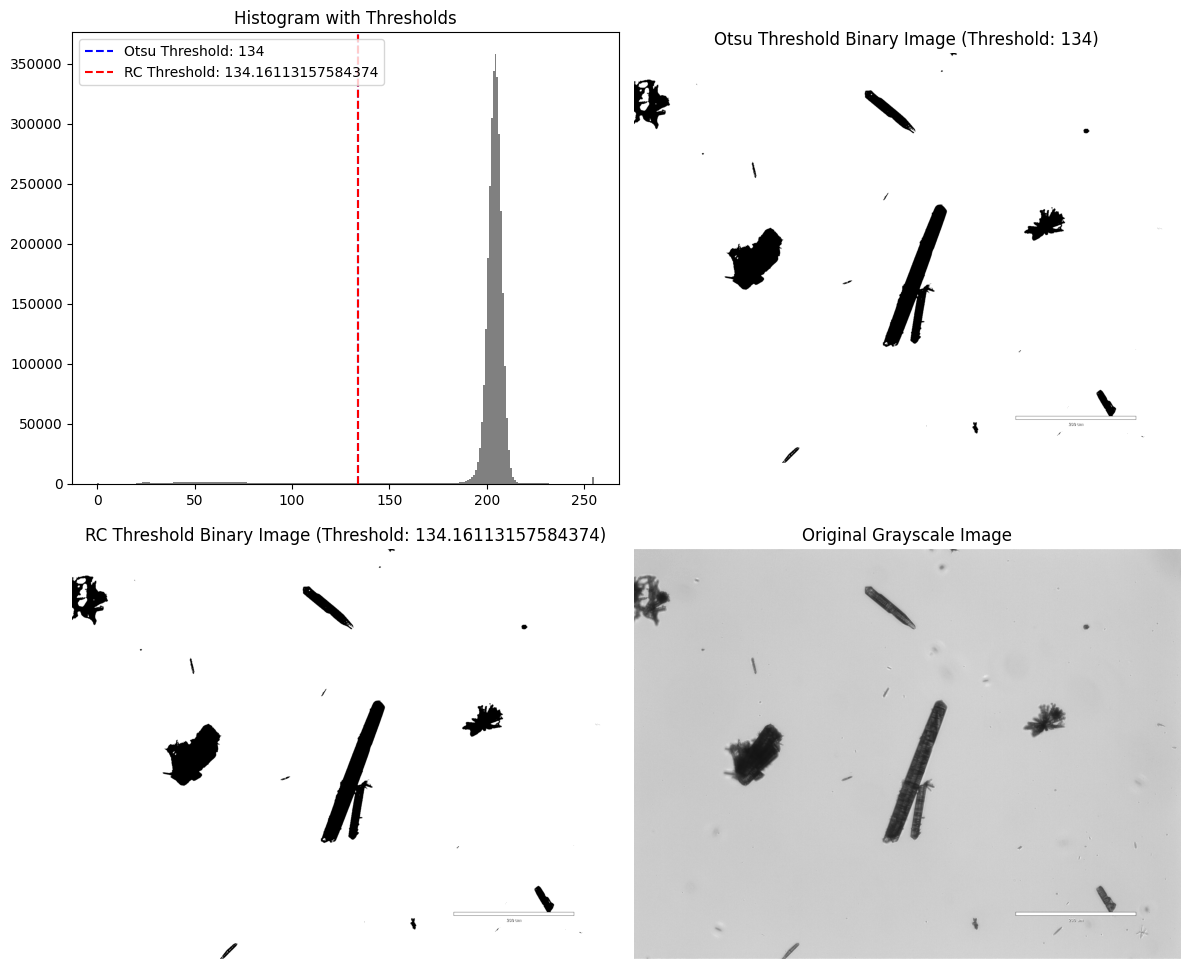

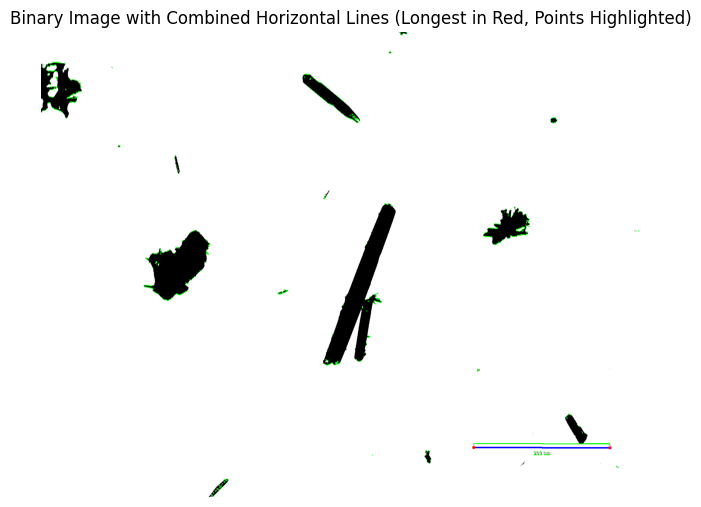

Length of the longest line in pixels: 450.00
Actual length per pixel: 0.8889 micrometers per pixel


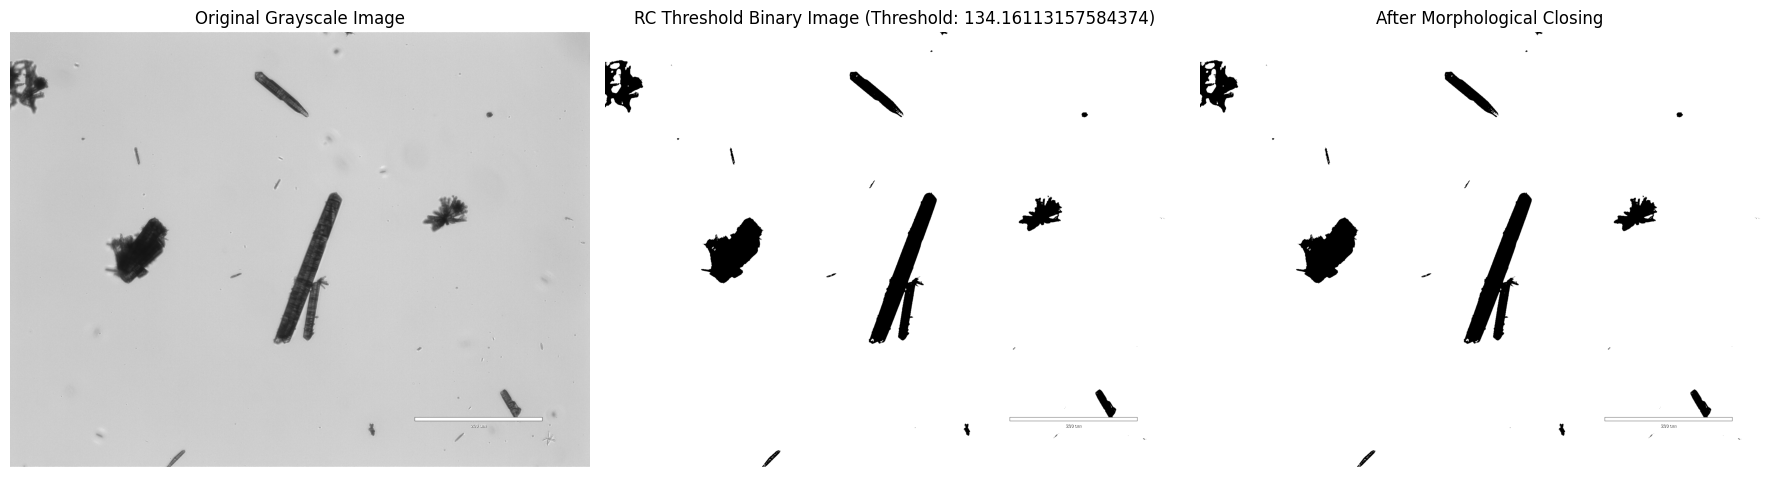

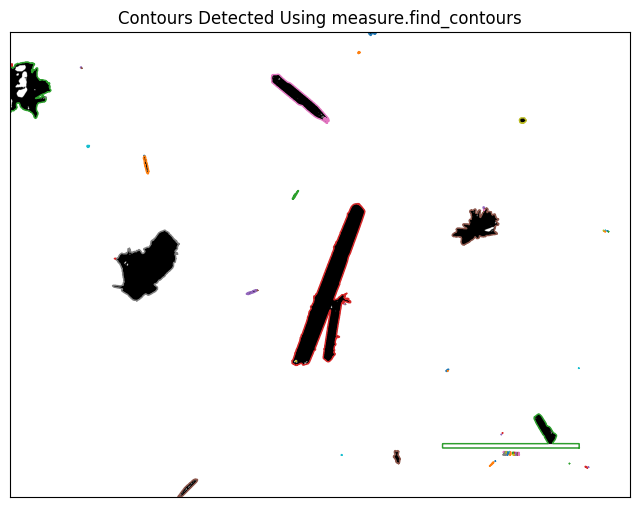

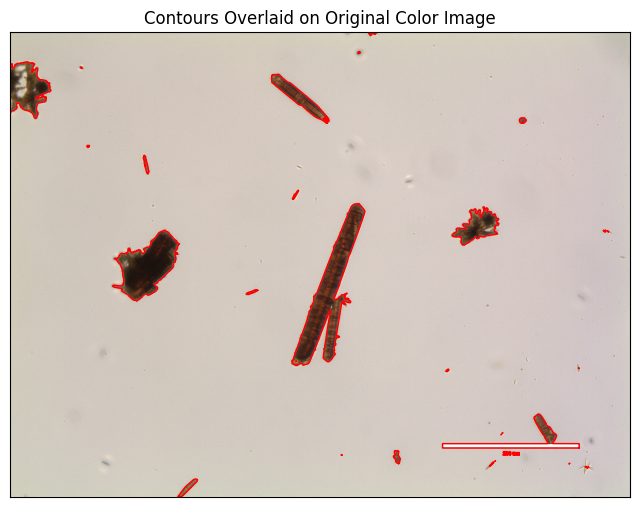

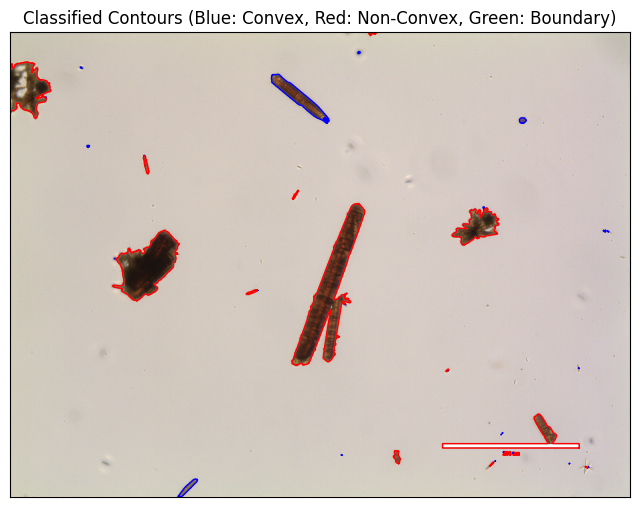

/var/folders/s_/rqrsj_qd1kj4qh2qrgpmv_800000gn/T/ipykernel_47089/837703178.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Total areas: 30, Total aspect ratios: 30


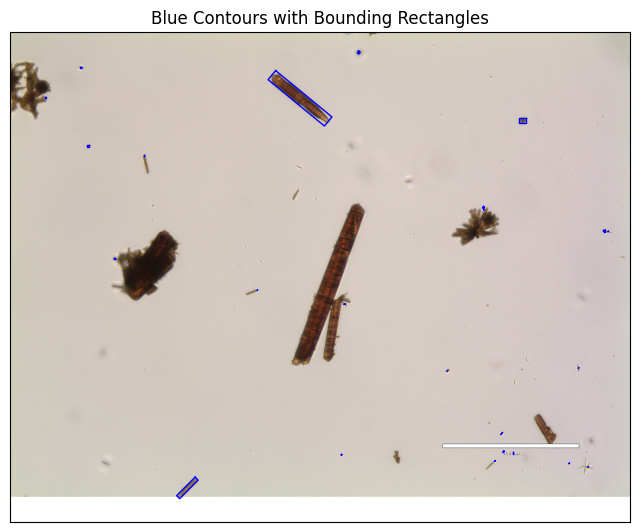

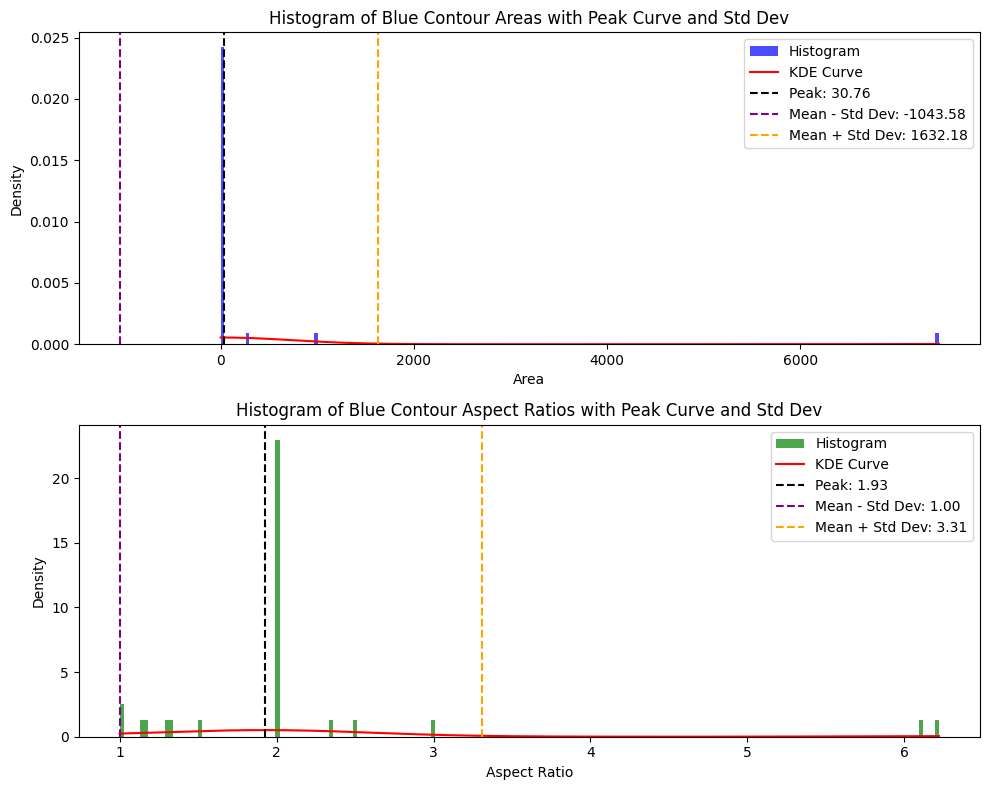

/var/folders/s_/rqrsj_qd1kj4qh2qrgpmv_800000gn/T/ipykernel_47089/3660853242.py:35: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


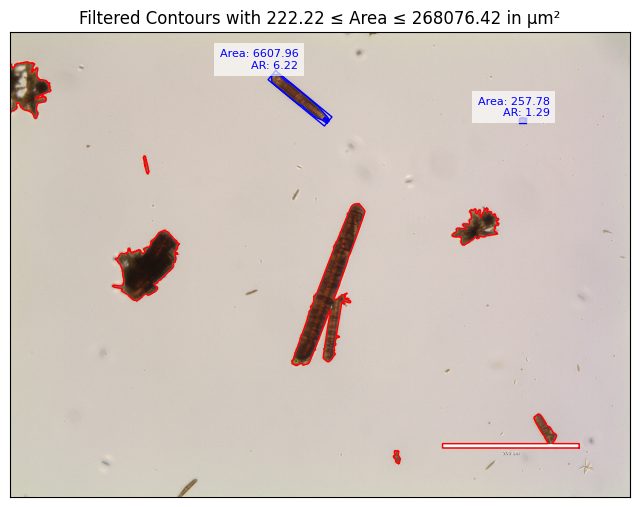

Mean Aspect Ratio (Blue Contours): 3.76
Standard Deviation (Blue Contours): 2.46


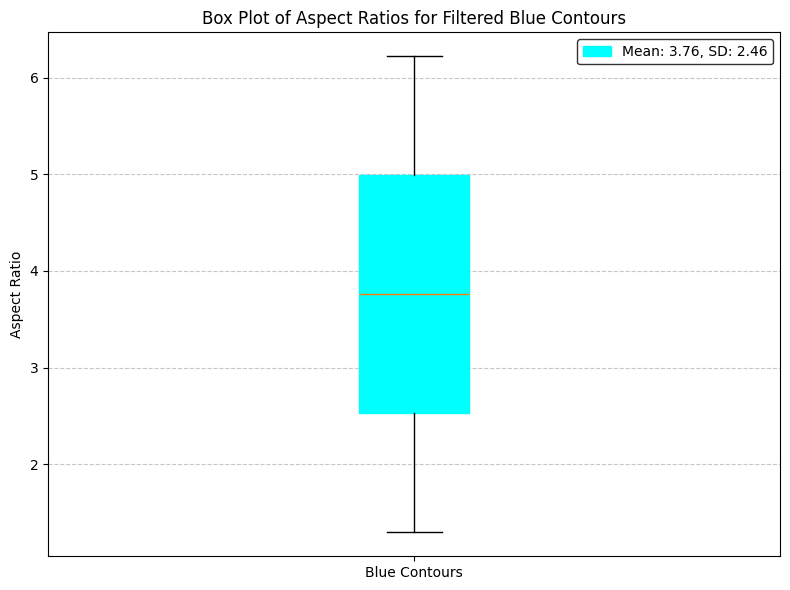

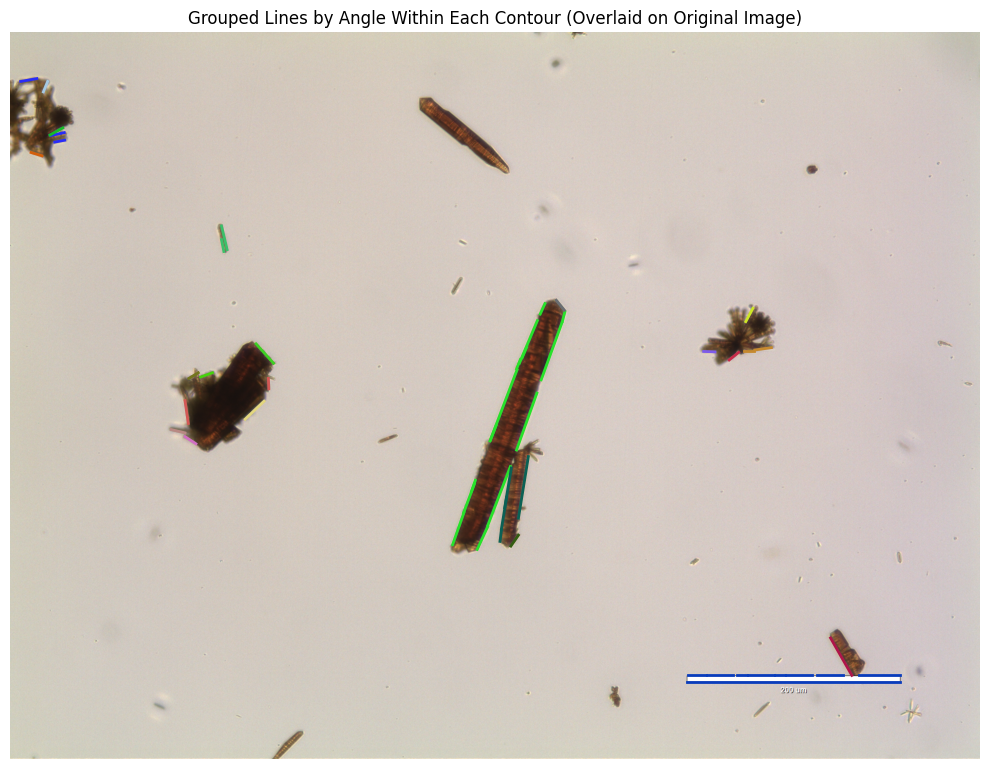

Grouped Lines Information for Remaining Red Contours:

Contour 1:
Number of Groups: 4
  Group 1: 3 lines
  Group 2: 1 lines
  Group 3: 1 lines
  Group 4: 1 lines

Contour 2:
Number of Groups: 1
  Group 1: 2 lines

Contour 3:
Number of Groups: 4
  Group 1: 14 lines
  Group 2: 4 lines
  Group 3: 1 lines
  Group 4: 1 lines

Contour 4:
Number of Groups: 4
  Group 1: 2 lines
  Group 2: 1 lines
  Group 3: 1 lines
  Group 4: 1 lines

Contour 5:
Number of Groups: 7
  Group 1: 1 lines
  Group 2: 1 lines
  Group 3: 2 lines
  Group 4: 1 lines
  Group 5: 1 lines
  Group 6: 1 lines
  Group 7: 1 lines

Contour 6:
Number of Groups: 2
  Group 1: 9 lines
  Group 2: 1 lines
Skipping contour with 7 grouped lines (exceeds 4).
Skipping box with aspect ratio 29.54 (not between 2 and 11.150520363737138)


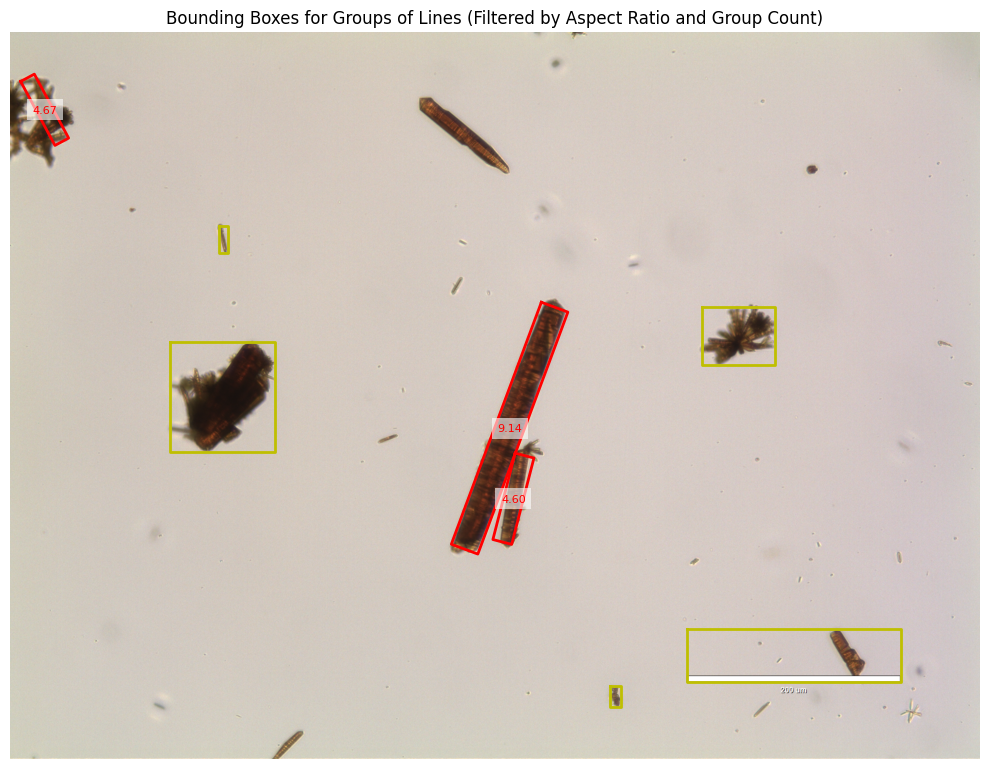

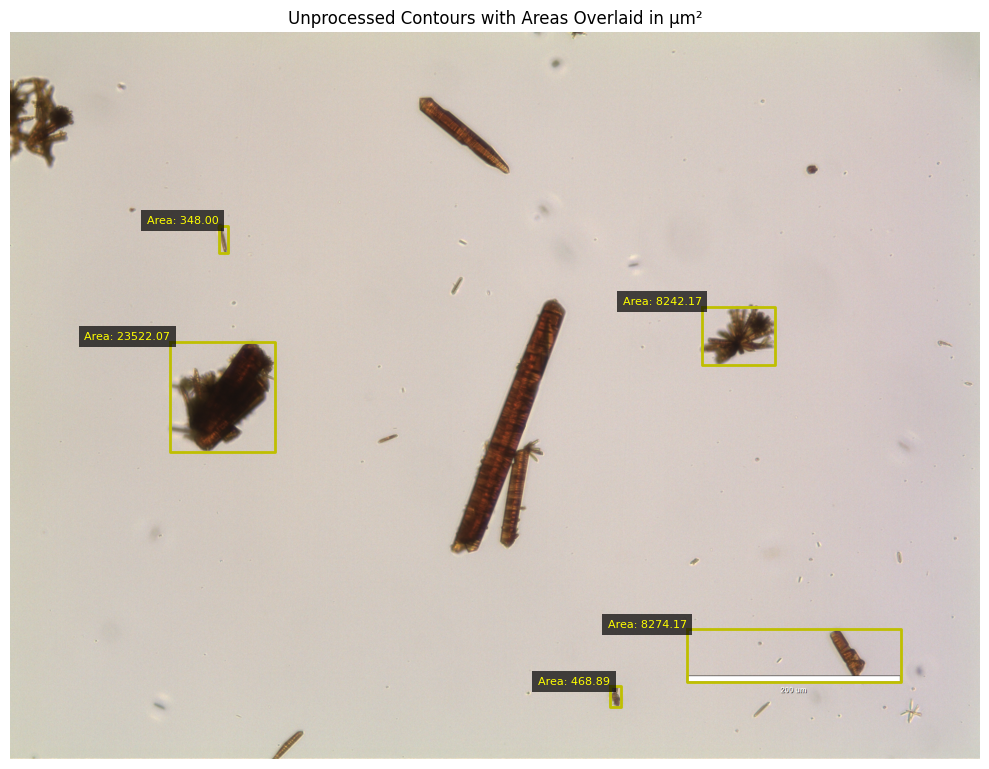

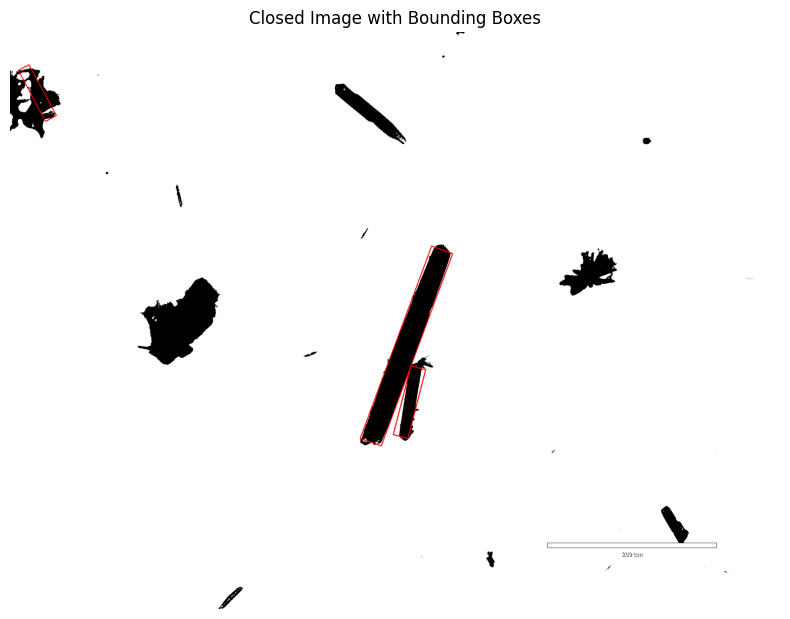

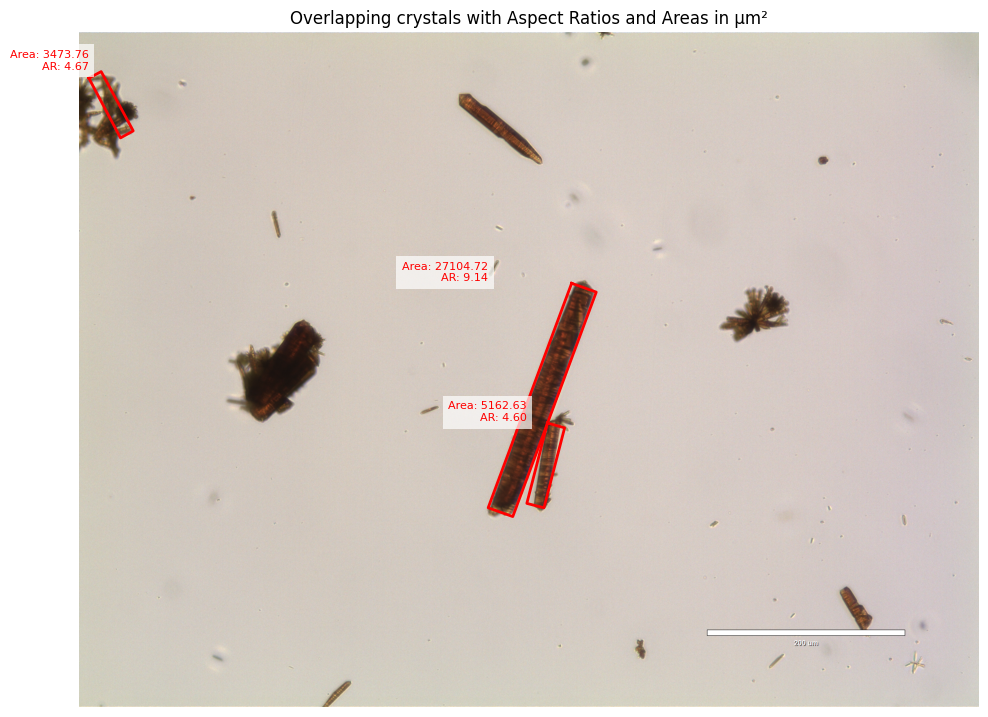

Blue Aspect Ratios : [6.222319005397981, 1.2941176470588236]
Red Aspect Ratios : [4.671474895363624, 9.136005413904938, 4.595057617391395]
Blue Areas : [6607.958231309609, 257.77614838307596]
Red Areas : [3473.75582027952, 27104.717560845293, 5162.634033823811]
Cluster Areas : [347.9978003171525, 8242.170123731281, 23522.07353995568, 8274.169921461595, 468.88592507611224]


In [31]:

def trail_run(image_path):
    # Example usage with your own image
    # image_path = '/Users/kchong99/Documents/UW_SUN_LAB/MOFs_Project/Condition_Test_V1/Condition 5 10th.tif'
    # Load and preprocess the image
    
    blue_aspect_ratios = [] 
    red_aspect_ratios= [] 
    actual_blue_contour_areas= [] 
    red_areas= [] 
    cluster_areas = []
    
    image = Image.open(image_path)
    image_gray = image_processing(image, 685, 1000)

    # Apply Mahotas Otsu and RC thresholding
    otsu_thresh, bin_otsu, rc_thresh, bin_rc = apply_mahotas_thresholding(image_gray)

    # Display the results
    display_binary_images_with_histogram(image_gray, otsu_thresh, bin_otsu, rc_thresh, bin_rc)
    
    
    ## Scale bar measurement
    # Detect all contours in the binary image using skimage
    contours = measure.find_contours(bin_rc, level=0.8)

    # Detect horizontal lines in contours
    horizontal_lines = detect_horizontal_lines(contours)

    # Combine horizontal lines that are close to each other
    combined_lines = combine_close_lines(horizontal_lines, pixel_tolerance=5)

    # Overlay combined horizontal lines on the binary image and highlight the longest in red
    overlay_image, longest_line = overlay_horizontal_lines(bin_rc, combined_lines)

    # Display the overlay
    display_overlay(overlay_image)

    # Assuming the actual length of the longest line is 200 micrometers
    actual_length_micrometers = 400

    # Print details of the longest line
    if longest_line:
        x1, y1, x2, y2 = longest_line
        length_in_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        if length_in_pixels < 400:
            length_in_pixels = 450
        
        length_per_pixel = actual_length_micrometers / length_in_pixels
        print(f"Length of the longest line in pixels: {length_in_pixels:.2f}")
        print(f"Actual length per pixel: {length_per_pixel:.4f} micrometers per pixel")
        
    else:
        print("No horizontal lines detected.")
        length_in_pixels = 450
        length_per_pixel = actual_length_micrometers / length_in_pixels
    
    
    # Apply RC thresholding
    rc_thresh, bin_rc = apply_rc_thresholding(image_gray)

    # Apply morphological closing on the RC thresholded binary image
    closed_image = apply_morphological_closing(bin_rc)

    # Display results before and after morphological closing
    display_rc_closing_results(image_gray, rc_thresh, bin_rc, closed_image)

    # Step 4: Normalize the closing image and find contours
    contours = normalize_and_find_contours(closed_image, contour_level=0.8)

    # Step 5: Filter out contours that enclose white regions
    contours = filter_and_remove_white_region_contours(closed_image, contours)

    # Step 5: Display the contours on the closing result
    display_contours(closed_image, contours)

    original_image = Image.open(image_path).convert('RGB')  # Load as color

    # Step 4: Display the contours overlaid on the original color image
    display_contours_on_original_color(original_image, contours)

    # Step 4: Classify contours based on convexity and identify boundary contours
    blue_contours, red_contours, boundary_contours = classify_contours_by_convexity(image_gray.shape, contours)

    # Step 5: Display the contours overlaid on the original color image, classified by convexity and boundary
    display_classified_contours_on_original_color(original_image, blue_contours, red_contours, boundary_contours)

    total_contours = len(blue_contours) + len(red_contours) + len(boundary_contours)

    if len(blue_contours) == 0:
        
        # blue_aspect_ratios = []
        # red_aspect_ratios = []
        # blue_contour_areas = []
        # red_areas = []
        # cluster_areas = []
        print("No single Crystals are detected")
        
    elif total_contours <= 2:
        # Assuming `original_image`, `blue_contours`, `red_contours`, and `boundary_contours` are defined
        blue_aspect_ratios, actual_blue_contour_areas = process_and_overlay_if_few_contours(
            original_image, blue_contours, red_contours, boundary_contours, length_per_pixel
        )
        
    else:
        blue_areas, blue_aspect_ratios = process_blue_contours(image_gray, original_image, blue_contours)
        
        # Assuming `areas`, `original_image`, `image_gray`, `blue_contours`, `red_contours`, and `green_contours` are defined
        peak_area, _, mean_area, std_dev_area, mean_ar, _ = plot_top_bottom_histograms_with_peak_curve_and_std(
            blue_areas, blue_aspect_ratios
        )

        # Replacement of Value (To ensure most contours are detected)
        if mean_area > 5000:
            mean_area = 1000
            
        elif mean_area < 1000:
            mean_area = 250

        filtered_blue_contours, blue_contour_areas, filtered_red_contours, filtered_green_contours, blue_aspect_ratios = filter_and_overlay_all_contours_with_upper_limit(
            original_image, image_gray, blue_contours, red_contours, boundary_contours, mean_area, std_dev_area, peak_area, length_per_pixel
        )
        
        actual_blue_contour_areas = []
        for idx, blue_contour_area in enumerate(blue_contour_areas):
            blue_contour_area = blue_contour_area * length_per_pixel
            actual_blue_contour_areas.append(blue_contour_area)
        
        # Finding the mean Aspect Ratio for the filtered blue contour
        mean_blue_ar, std_dev_blue_ar = analyze_and_plot_blue_aspect_ratios(blue_aspect_ratios)
        
        binary_background = np.zeros_like(image_gray, dtype=np.uint8)
        
        #Caluclate if crystals are circular shape or rectangular shape
        if mean_blue_ar >= 2:
        
            # Step 1: Detect and group lines within each contour based on angle similarity
            grouped_lines_per_contour = detect_and_group_lines_per_contour(binary_background, filtered_red_contours, group_threshold=10)

            # Step 2: Plot the grouped lines for each contour on the original image
            plot_grouped_lines_per_contour_on_original_image(original_image, grouped_lines_per_contour)
            
            count_and_print_grouped_lines_per_contour(grouped_lines_per_contour, filtered_red_contours)
            
            # # Plot the minimum bounding boxes for groups with more than 3 lines and valid aspect ratios
            # red_aspect_ratios = plot_minimum_bounding_boxes_for_large_groups_with_aspect_ratios(
            #     original_image, grouped_lines_per_contour, filtered_red_contours, min_AR=2, max_AR=mean_blue_ar + 3 * std_dev_blue_ar, max_groups=5
            # )
            
            ## Processing Clusters and Red AR
            red_aspect_ratios, processed_contours, unprocessed_contours, box_information = plot_minimum_bounding_boxes_with_yellow_for_remaining(
                original_image, grouped_lines_per_contour, filtered_red_contours, min_AR=2, max_AR=mean_blue_ar + 3 * std_dev_blue_ar, max_groups=4
            )
            
            cluster_areas = overlay_unprocessed_contour_areas(original_image, unprocessed_contours, length_per_pixel)
            
            ## Overlapping Crystals
            # Apply morphological closing to fill white pixels
            closed_image = apply_morphological_closing(bin_rc)

            # Overlay the box information on the closed image
            closed_image_with_boxes = overlay_boxes_on_closed_image(closed_image, box_information)

            # Display the closed image with bounding boxes
            display_closed_image_with_boxes(closed_image_with_boxes)
            
            red_areas = overlay_black_pixel_counts_and_aspect_ratios_on_original(
                original_image, closed_image, box_information, red_aspect_ratios, length_per_pixel
            )
                
        else:
            # Extract, overlay, and print aspect ratios and areas for the red contours
            _, cluster_areas = overlay_aspect_ratios_on_red_contours_ar_less_than_2(   #red_aspect_ratios
                original_image, image_gray, filtered_red_contours, length_per_pixel
            )
            
    return blue_aspect_ratios, red_aspect_ratios, actual_blue_contour_areas, red_areas, cluster_areas



blue_aspect_ratios, red_aspect_ratios, actual_blue_contour_areas, red_areas, cluster_areas = trail_run('/Users/kchong99/Documents/UW_SUN_LAB/MOFs_Project/Condition_Test_V1/Condition 6 6th.tif')
    
print(f"Blue Aspect Ratios : {blue_aspect_ratios}")
print(f"Red Aspect Ratios : {red_aspect_ratios}")
print(f"Blue Areas : {actual_blue_contour_areas}")
print(f"Red Areas : {red_areas}")
print(f"Cluster Areas : {cluster_areas}")



## Data Analysis

In [29]:
import pandas as pd
from IPython.display import display

def create_summary_table(
    aspect_ratios_single, aspect_ratios_overlapping,
    areas_single, areas_overlapping, areas_clusters
):
    """
    Create a summary table with the count of contours, mean aspect ratios, and mean areas for single crystals,
    overlapping crystals, and clusters.

    Parameters:
    - single_crystals: List of single crystals.
    - overlapping_crystals: List of overlapping crystals.
    - clusters: List of clusters.
    - aspect_ratios_single: List of aspect ratios for single crystals.
    - aspect_ratios_overlapping: List of aspect ratios for overlapping crystals.
    - aspect_ratios_clusters: List of aspect ratios for clusters.
    - areas_single: List of areas for single crystals.
    - areas_overlapping: List of areas for overlapping crystals.
    - areas_clusters: List of areas for clusters.

    Returns:
    - summary_table: Pandas DataFrame containing the summary.
    """
    # Calculate counts
    count_single_crystals = len(aspect_ratios_single)
    count_overlapping_crystals = len(aspect_ratios_overlapping)
    count_clusters = len(areas_clusters)

    # Calculate mean aspect ratios
    mean_ar_single = round(np.mean(aspect_ratios_single), 2) if aspect_ratios_single else 0
    mean_ar_overlapping = round(np.mean(aspect_ratios_overlapping), 2) if aspect_ratios_overlapping else 0
    mean_ar_clusters = "-"

    # Calculate mean areas
    mean_area_single = round(np.mean(areas_single), 2) if areas_single else 0
    mean_area_overlapping = round(np.mean(areas_overlapping), 2) if areas_overlapping else 0
    mean_area_clusters = round(np.mean(areas_clusters), 2) if areas_clusters else 0

    # Calculate totals
    total_count = count_single_crystals + count_overlapping_crystals
    total_aspect_ratios = aspect_ratios_single + aspect_ratios_overlapping
    total_mean_ar = round(np.mean(total_aspect_ratios), 2) if total_aspect_ratios else 0
    total_areas = areas_single + areas_overlapping 
    total_mean_area = round(np.mean(total_areas), 2) if total_areas else 0

    # Create the summary table
    summary_table = pd.DataFrame({
        "Category": ["Single Crystals", "Overlapping Crystals", "Total", "Clusters"],
        "Count": [count_single_crystals, count_overlapping_crystals, total_count, count_clusters],
        "Mean Aspect Ratio": [mean_ar_single, mean_ar_overlapping, total_mean_ar, mean_ar_clusters],
        "Mean Area (µm²)": [mean_area_single, mean_area_overlapping, total_mean_area,mean_area_clusters]
    })

    return summary_table


# Example Data
# Generate the summary table
summary_table = create_summary_table(
    blue_aspect_ratios, red_aspect_ratios,
    actual_blue_contour_areas, red_areas, cluster_areas
)

# Display the summary table
display(summary_table)


Category  Count Mean Aspect Ratio  Mean Area (µm²)
0       Single Crystals      3              1.13         27301.75
1  Overlapping Crystals      0                 0             0.00
2                 Total      3              1.13         27301.75
3              Clusters      0                 -             0.00

In [25]:
## if no blue contour then print print there are bno single crystals detected 

In [26]:
a = actual_blue_contour_areas +  [556, 58280, 571.55, 2523.10, 955.2]
b = blue_aspect_ratios + [1.31, 1.30, 1.15, 1.07, 1.22]
print(a)
print(b)

[387.30158730158735, 310.2040816326531, 8179.591836734694, 3201.814058956916, 602.2675736961452, 295.6916099773243, 944.21768707483, 521.5419501133787, 311.11111111111114, 8298.4126984127, 1213.6054421768708, 556, 58280, 571.55, 2523.1, 955.2]
[1.1911764743911946, 3.1893003755939047, 3.4119758156033613, 3.1794871794871793, 2.5105633718170144, 1.9090908087744407, 2.5652173913043477, 1.5088340074390785, 1.0952380952380953, 3.080303229580071, 1.5401196889625968, 1.31, 1.3, 1.15, 1.07, 1.22]
